### Baseline Iris dataset random classifier & Logistic classifier

The purpose of this section is to get a baseline for how performance looks on the classification task with the unmodified Iris dataset. We will be randomly losing data in this dataset at varying percentages and using various imputation strategies to compare and see what the performance implications are.

In [1]:
from sklearn.experimental import enable_iterative_imputer

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [3]:
# import the iris dataset
iris = datasets.load_iris()
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### Loading that raw data into a `raw_df`

In [4]:
raw_df = pd.DataFrame.from_dict({**{feature:list(map(lambda row: row[idx], iris["data"])) 
                              for idx, feature in enumerate(iris["feature_names"])},
                               **{"class":iris["target"]}})
raw_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0
7,5.0,3.4,1.5,0.2,0
8,4.4,2.9,1.4,0.2,0
9,4.9,3.1,1.5,0.1,0


### Baseline feature scaling

In [5]:
import random
X_raw, y_raw = raw_df.iloc[:,0:-1], raw_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=random.randint(1,101)
)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # Scaler was fit on the training data only
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Dummy & Logistic Regression $F_1$ scores with `100.0%` of data

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
def get_scores(X_train, y_train, X_test, y_test):
    y_test_hat = DummyClassifier().fit(X_train, y_train).predict(X_test)
    scores = pd.DataFrame(data=[f1_score(y_test, y_test_hat, average='weighted')],
                          index=[100.0],
                          columns=["dummy"])
    y_test_hat = LogisticRegression(solver="lbfgs", multi_class="auto").fit(X_train, y_train).predict(X_test)
    scores['logisticreg'] = pd.Series([f1_score(y_test, y_test_hat, average='weighted')],
                                  index=[100.0])
    return scores
get_scores(X_train, y_train, X_test, y_test)

,dummy,logisticreg
100.0,0.440829,0.966922


As we continue with the notebook, we will fill up this dataframe with the result of varying levels of random data-loss (`80.0%` indicates that we draw from a uniform distribution of all elements in `X` and randomly keep `80%` of values, discarding `20%`.

### Dummy & Logistic Regression $F_1$ scores with `[25%, 99%]` of data stepping by `1%`

In [7]:
import itertools
import numpy as np
def drop_percentage(df, p):
    new_df = df.copy()
    for i, j in itertools.product(*map(lambda dx: range(dx), df.shape)):
        if np.random.rand(1)[0] >= p: new_df[i,j] = np.nan
    return new_df
def percentages(): return np.arange(0.25,1,0.01)
X_train_percentage = {
    percentage:{"dirty":drop_percentage(X_train, percentage)} for percentage in percentages()
}
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
for percentage in percentages():
    def get_dirty_data(): return X_train_percentage[percentage]["dirty"]
    X_train_percentage[percentage]["clean"] = {
        "mean":SimpleImputer().fit_transform(get_dirty_data()),
        "iter":IterativeImputer().fit_transform(get_dirty_data())
    }

d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\si

d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
d:\anaconda3\envs\imputation\lib\si

In [8]:
def methods(): return ["mean", "iter"]
all_scores = {method:{} for method in methods()}
def method_perc_cartprod(): return itertools.product(methods(), percentages())
for method, percentage in method_perc_cartprod():
    all_scores[method][percentage] = get_scores(
        X_train_percentage[percentage]["clean"][method], y_train, X_test, y_test
    )
from IPython.display import display, HTML
for method, percentage in method_perc_cartprod():
    print(f"PERCENTAGE={percentage}")
    display(HTML(all_scores[method][percentage].to_html()))

PERCENTAGE=0.25


,dummy,logisticreg
100.0,0.350034,0.900752


PERCENTAGE=0.26


,dummy,logisticreg
100.0,0.194949,0.897354


PERCENTAGE=0.27


,dummy,logisticreg
100.0,0.319865,0.866667


PERCENTAGE=0.28


,dummy,logisticreg
100.0,0.365611,0.900752


PERCENTAGE=0.29000000000000004


,dummy,logisticreg
100.0,0.387614,0.900752


PERCENTAGE=0.30000000000000004


,dummy,logisticreg
100.0,0.335557,0.822329


PERCENTAGE=0.31000000000000005


,dummy,logisticreg
100.0,0.290413,0.602413


PERCENTAGE=0.32000000000000006


,dummy,logisticreg
100.0,0.303302,0.900752


PERCENTAGE=0.33000000000000007


,dummy,logisticreg
100.0,0.365856,0.866667


PERCENTAGE=0.3400000000000001


,dummy,logisticreg
100.0,0.259449,0.866667


PERCENTAGE=0.3500000000000001


,dummy,logisticreg
100.0,0.228283,0.900752


PERCENTAGE=0.3600000000000001


,dummy,logisticreg
100.0,0.36466,0.711111


PERCENTAGE=0.3700000000000001


,dummy,logisticreg
100.0,0.439394,0.900752


PERCENTAGE=0.3800000000000001


,dummy,logisticreg
100.0,0.24,0.866667


PERCENTAGE=0.3900000000000001


,dummy,logisticreg
100.0,0.288448,0.900752


PERCENTAGE=0.40000000000000013


,dummy,logisticreg
100.0,0.606061,0.897354


PERCENTAGE=0.41000000000000014


,dummy,logisticreg
100.0,0.356671,0.866667


PERCENTAGE=0.42000000000000015


,dummy,logisticreg
100.0,0.216268,0.934007


PERCENTAGE=0.43000000000000016


,dummy,logisticreg
100.0,0.414815,0.866667


PERCENTAGE=0.44000000000000017


,dummy,logisticreg
100.0,0.32963,0.900752


PERCENTAGE=0.4500000000000002


,dummy,logisticreg
100.0,0.386667,0.900752


PERCENTAGE=0.4600000000000002


,dummy,logisticreg
100.0,0.316658,0.934007


PERCENTAGE=0.4700000000000002


,dummy,logisticreg
100.0,0.365809,0.897354


PERCENTAGE=0.4800000000000002


,dummy,logisticreg
100.0,0.328283,0.900752


PERCENTAGE=0.4900000000000002


,dummy,logisticreg
100.0,0.299448,0.900752


PERCENTAGE=0.5000000000000002


,dummy,logisticreg
100.0,0.472323,0.866667


PERCENTAGE=0.5100000000000002


,dummy,logisticreg
100.0,0.161438,0.934007


PERCENTAGE=0.5200000000000002


,dummy,logisticreg
100.0,0.234576,0.934007


PERCENTAGE=0.5300000000000002


,dummy,logisticreg
100.0,0.406667,0.966922


PERCENTAGE=0.5400000000000003


,dummy,logisticreg
100.0,0.304714,0.897354


PERCENTAGE=0.5500000000000003


,dummy,logisticreg
100.0,0.392638,0.934007


PERCENTAGE=0.5600000000000003


,dummy,logisticreg
100.0,0.296594,0.934007


PERCENTAGE=0.5700000000000003


,dummy,logisticreg
100.0,0.346667,0.866667


PERCENTAGE=0.5800000000000003


,dummy,logisticreg
100.0,0.412732,0.934007


PERCENTAGE=0.5900000000000003


,dummy,logisticreg
100.0,0.263147,0.934007


PERCENTAGE=0.6000000000000003


,dummy,logisticreg
100.0,0.285877,0.866667


PERCENTAGE=0.6100000000000003


,dummy,logisticreg
100.0,0.33135,0.934007


PERCENTAGE=0.6200000000000003


,dummy,logisticreg
100.0,0.450409,0.900752


PERCENTAGE=0.6300000000000003


,dummy,logisticreg
100.0,0.346617,0.934007


PERCENTAGE=0.6400000000000003


,dummy,logisticreg
100.0,0.377778,0.934007


PERCENTAGE=0.6500000000000004


,dummy,logisticreg
100.0,0.408254,0.934007


PERCENTAGE=0.6600000000000004


,dummy,logisticreg
100.0,0.333282,0.966922


PERCENTAGE=0.6700000000000004


,dummy,logisticreg
100.0,0.450101,0.934007


PERCENTAGE=0.6800000000000004


,dummy,logisticreg
100.0,0.432477,0.934007


PERCENTAGE=0.6900000000000004


,dummy,logisticreg
100.0,0.40292,0.934007


PERCENTAGE=0.7000000000000004


,dummy,logisticreg
100.0,0.427314,0.934007


PERCENTAGE=0.7100000000000004


,dummy,logisticreg
100.0,0.23376,0.934007


PERCENTAGE=0.7200000000000004


,dummy,logisticreg
100.0,0.304714,0.934007


PERCENTAGE=0.7300000000000004


,dummy,logisticreg
100.0,0.308521,0.934007


PERCENTAGE=0.7400000000000004


,dummy,logisticreg
100.0,0.369697,0.934007


PERCENTAGE=0.7500000000000004


,dummy,logisticreg
100.0,0.437935,0.934007


PERCENTAGE=0.7600000000000005


,dummy,logisticreg
100.0,0.366667,0.966922


PERCENTAGE=0.7700000000000005


,dummy,logisticreg
100.0,0.310572,0.966922


PERCENTAGE=0.7800000000000005


,dummy,logisticreg
100.0,0.163955,0.966922


PERCENTAGE=0.7900000000000005


,dummy,logisticreg
100.0,0.202357,0.966922


PERCENTAGE=0.8000000000000005


,dummy,logisticreg
100.0,0.299312,0.966922


PERCENTAGE=0.8100000000000005


,dummy,logisticreg
100.0,0.166667,0.966922


PERCENTAGE=0.8200000000000005


,dummy,logisticreg
100.0,0.336591,0.934007


PERCENTAGE=0.8300000000000005


,dummy,logisticreg
100.0,0.296296,0.966922


PERCENTAGE=0.8400000000000005


,dummy,logisticreg
100.0,0.277109,0.966922


PERCENTAGE=0.8500000000000005


,dummy,logisticreg
100.0,0.39943,0.966922


PERCENTAGE=0.8600000000000005


,dummy,logisticreg
100.0,0.292051,0.966922


PERCENTAGE=0.8700000000000006


,dummy,logisticreg
100.0,0.336707,0.966922


PERCENTAGE=0.8800000000000006


,dummy,logisticreg
100.0,0.206667,0.934007


PERCENTAGE=0.8900000000000006


,dummy,logisticreg
100.0,0.286443,0.966922


PERCENTAGE=0.9000000000000006


,dummy,logisticreg
100.0,0.358802,0.966922


PERCENTAGE=0.9100000000000006


,dummy,logisticreg
100.0,0.516402,0.966922


PERCENTAGE=0.9200000000000006


,dummy,logisticreg
100.0,0.399174,0.966922


PERCENTAGE=0.9300000000000006


,dummy,logisticreg
100.0,0.334871,0.966922


PERCENTAGE=0.9400000000000006


,dummy,logisticreg
100.0,0.293333,0.966922


PERCENTAGE=0.9500000000000006


,dummy,logisticreg
100.0,0.364311,0.966922


PERCENTAGE=0.9600000000000006


,dummy,logisticreg
100.0,0.434697,0.966922


PERCENTAGE=0.9700000000000006


,dummy,logisticreg
100.0,0.304906,0.966922


PERCENTAGE=0.9800000000000006


,dummy,logisticreg
100.0,0.273913,0.966922


PERCENTAGE=0.9900000000000007


,dummy,logisticreg
100.0,0.28083,0.966922


PERCENTAGE=0.25


,dummy,logisticreg
100.0,0.389226,0.966922


PERCENTAGE=0.26


,dummy,logisticreg
100.0,0.293829,0.934007


PERCENTAGE=0.27


,dummy,logisticreg
100.0,0.261333,0.866667


PERCENTAGE=0.28


,dummy,logisticreg
100.0,0.47037,0.897354


PERCENTAGE=0.29000000000000004


,dummy,logisticreg
100.0,0.444275,0.966922


PERCENTAGE=0.30000000000000004


,dummy,logisticreg
100.0,0.209524,0.900752


PERCENTAGE=0.31000000000000005


,dummy,logisticreg
100.0,0.356825,0.862022


PERCENTAGE=0.32000000000000006


,dummy,logisticreg
100.0,0.296421,0.900752


PERCENTAGE=0.33000000000000007


,dummy,logisticreg
100.0,0.33193,0.866667


PERCENTAGE=0.3400000000000001


,dummy,logisticreg
100.0,0.268783,0.966922


PERCENTAGE=0.3500000000000001


,dummy,logisticreg
100.0,0.395474,0.933333


PERCENTAGE=0.3600000000000001


,dummy,logisticreg
100.0,0.29457,0.966922


PERCENTAGE=0.3700000000000001


,dummy,logisticreg
100.0,0.367735,0.866667


PERCENTAGE=0.3800000000000001


,dummy,logisticreg
100.0,0.276737,0.966922


PERCENTAGE=0.3900000000000001


,dummy,logisticreg
100.0,0.270503,0.966922


PERCENTAGE=0.40000000000000013


,dummy,logisticreg
100.0,0.299529,0.932077


PERCENTAGE=0.41000000000000014


,dummy,logisticreg
100.0,0.559398,0.934007


PERCENTAGE=0.42000000000000015


,dummy,logisticreg
100.0,0.319649,1.0


PERCENTAGE=0.43000000000000016


,dummy,logisticreg
100.0,0.243062,0.934007


PERCENTAGE=0.44000000000000017


,dummy,logisticreg
100.0,0.42259,0.966922


PERCENTAGE=0.4500000000000002


,dummy,logisticreg
100.0,0.306878,0.966922


PERCENTAGE=0.4600000000000002


,dummy,logisticreg
100.0,0.403175,0.934007


PERCENTAGE=0.4700000000000002


,dummy,logisticreg
100.0,0.339292,0.934007


PERCENTAGE=0.4800000000000002


,dummy,logisticreg
100.0,0.338435,0.934007


PERCENTAGE=0.4900000000000002


,dummy,logisticreg
100.0,0.463206,0.966922


PERCENTAGE=0.5000000000000002


,dummy,logisticreg
100.0,0.299841,0.934007


PERCENTAGE=0.5100000000000002


,dummy,logisticreg
100.0,0.370794,0.966922


PERCENTAGE=0.5200000000000002


,dummy,logisticreg
100.0,0.393329,0.966922


PERCENTAGE=0.5300000000000002


,dummy,logisticreg
100.0,0.380875,0.966922


PERCENTAGE=0.5400000000000003


,dummy,logisticreg
100.0,0.326667,0.966922


PERCENTAGE=0.5500000000000003


,dummy,logisticreg
100.0,0.318341,1.0


PERCENTAGE=0.5600000000000003


,dummy,logisticreg
100.0,0.261616,0.966922


PERCENTAGE=0.5700000000000003


,dummy,logisticreg
100.0,0.228333,0.966922


PERCENTAGE=0.5800000000000003


,dummy,logisticreg
100.0,0.464109,0.966922


PERCENTAGE=0.5900000000000003


,dummy,logisticreg
100.0,0.347335,0.966922


PERCENTAGE=0.6000000000000003


,dummy,logisticreg
100.0,0.361905,0.966922


PERCENTAGE=0.6100000000000003


,dummy,logisticreg
100.0,0.331195,0.966922


PERCENTAGE=0.6200000000000003


,dummy,logisticreg
100.0,0.330736,0.966922


PERCENTAGE=0.6300000000000003


,dummy,logisticreg
100.0,0.527003,0.966922


PERCENTAGE=0.6400000000000003


,dummy,logisticreg
100.0,0.331429,0.966922


PERCENTAGE=0.6500000000000004


,dummy,logisticreg
100.0,0.282899,0.966922


PERCENTAGE=0.6600000000000004


,dummy,logisticreg
100.0,0.473333,0.966922


PERCENTAGE=0.6700000000000004


,dummy,logisticreg
100.0,0.3,0.966922


PERCENTAGE=0.6800000000000004


,dummy,logisticreg
100.0,0.535111,0.966922


PERCENTAGE=0.6900000000000004


,dummy,logisticreg
100.0,0.263477,1.0


PERCENTAGE=0.7000000000000004


,dummy,logisticreg
100.0,0.456296,0.966922


PERCENTAGE=0.7100000000000004


,dummy,logisticreg
100.0,0.41751,0.966922


PERCENTAGE=0.7200000000000004


,dummy,logisticreg
100.0,0.320205,0.966922


PERCENTAGE=0.7300000000000004


,dummy,logisticreg
100.0,0.341077,0.966922


PERCENTAGE=0.7400000000000004


,dummy,logisticreg
100.0,0.264421,0.966922


PERCENTAGE=0.7500000000000004


,dummy,logisticreg
100.0,0.340877,0.966922


PERCENTAGE=0.7600000000000005


,dummy,logisticreg
100.0,0.230688,0.966922


PERCENTAGE=0.7700000000000005


,dummy,logisticreg
100.0,0.211395,0.966922


PERCENTAGE=0.7800000000000005


,dummy,logisticreg
100.0,0.344444,0.966922


PERCENTAGE=0.7900000000000005


,dummy,logisticreg
100.0,0.433412,0.966922


PERCENTAGE=0.8000000000000005


,dummy,logisticreg
100.0,0.298653,0.966922


PERCENTAGE=0.8100000000000005


,dummy,logisticreg
100.0,0.405024,0.966922


PERCENTAGE=0.8200000000000005


,dummy,logisticreg
100.0,0.320238,0.966922


PERCENTAGE=0.8300000000000005


,dummy,logisticreg
100.0,0.243062,0.966922


PERCENTAGE=0.8400000000000005


,dummy,logisticreg
100.0,0.333229,0.966922


PERCENTAGE=0.8500000000000005


,dummy,logisticreg
100.0,0.262963,0.966922


PERCENTAGE=0.8600000000000005


,dummy,logisticreg
100.0,0.286048,0.966922


PERCENTAGE=0.8700000000000006


,dummy,logisticreg
100.0,0.217778,0.966922


PERCENTAGE=0.8800000000000006


,dummy,logisticreg
100.0,0.311145,0.966922


PERCENTAGE=0.8900000000000006


,dummy,logisticreg
100.0,0.30101,0.966922


PERCENTAGE=0.9000000000000006


,dummy,logisticreg
100.0,0.213333,0.966922


PERCENTAGE=0.9100000000000006


,dummy,logisticreg
100.0,0.298654,0.966922


PERCENTAGE=0.9200000000000006


,dummy,logisticreg
100.0,0.432095,0.966922


PERCENTAGE=0.9300000000000006


,dummy,logisticreg
100.0,0.343541,0.966922


PERCENTAGE=0.9400000000000006


,dummy,logisticreg
100.0,0.392344,0.966922


PERCENTAGE=0.9500000000000006


,dummy,logisticreg
100.0,0.337644,0.966922


PERCENTAGE=0.9600000000000006


,dummy,logisticreg
100.0,0.6,0.966922


PERCENTAGE=0.9700000000000006


,dummy,logisticreg
100.0,0.332929,0.966922


PERCENTAGE=0.9800000000000006


,dummy,logisticreg
100.0,0.295873,0.966922


PERCENTAGE=0.9900000000000007


,dummy,logisticreg
100.0,0.274663,0.966922


In [9]:
all_scores["mean"][0.25]["dummy"].values[0]

0.35003367003367003

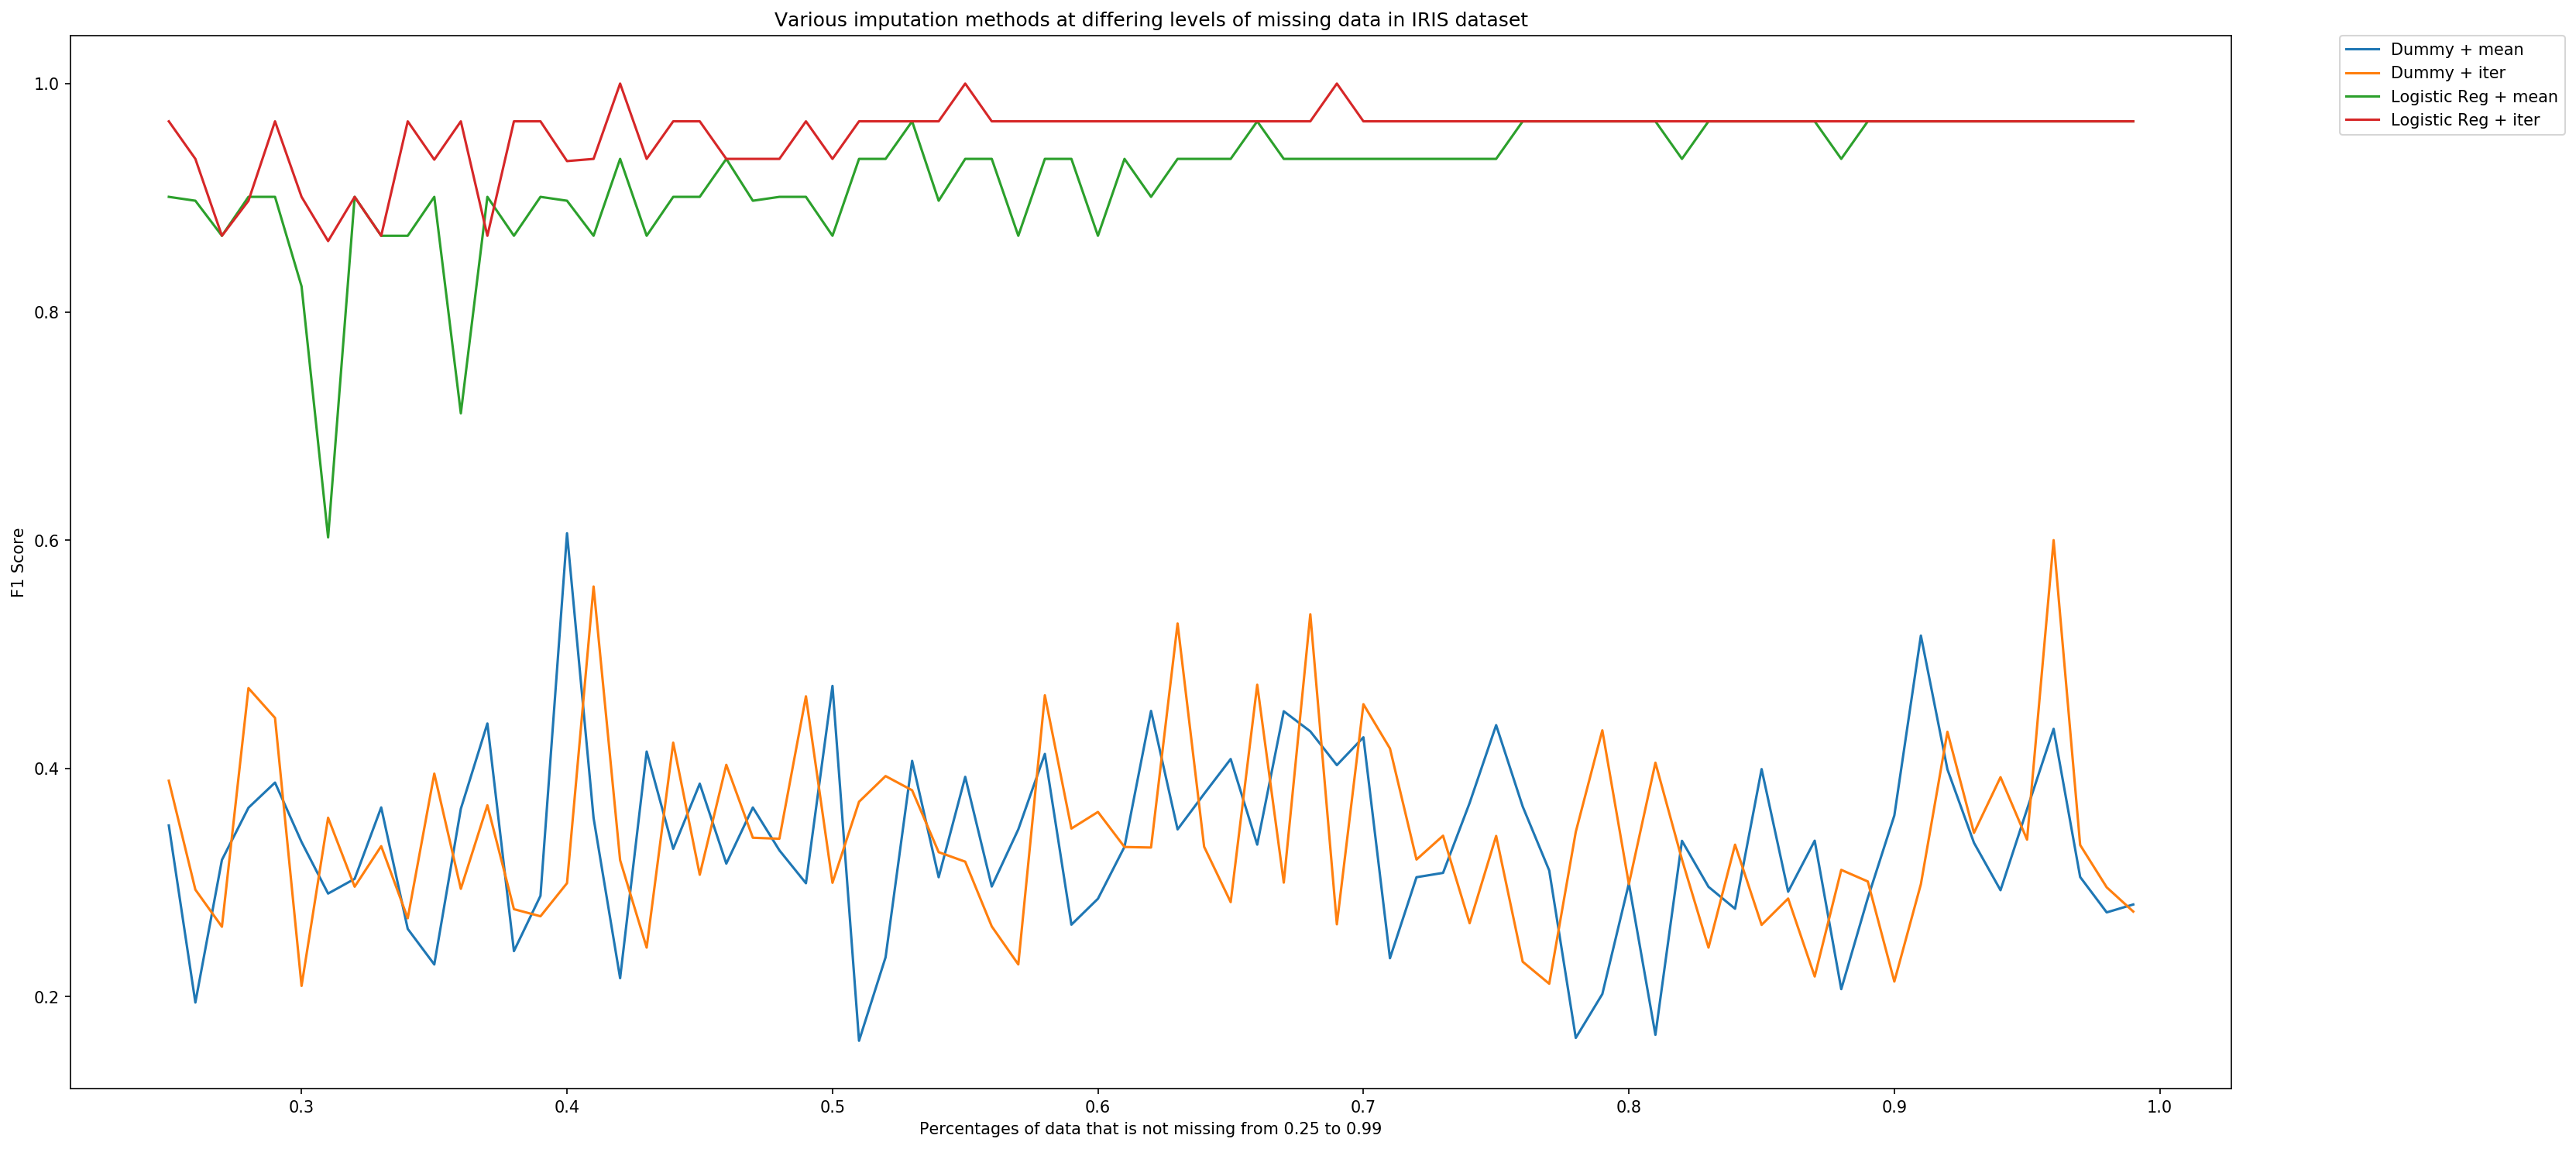

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(24, 12), dpi=150, facecolor='w', edgecolor='k')
dummy_lines = {
    method:plt.plot(percentages(), [
        all_scores[method][percentage]["dummy"].values[0] for percentage in percentages()
    ], label=f"Dummy + {method}") for method in methods()
}
logisticreg_lines = {
    method:plt.plot(percentages(), [
        all_scores[method][percentage]["logisticreg"].values[0] for percentage in percentages()
    ], label=f"Logistic Reg + {method}") for method in methods()
}
plt.xlabel(f"Percentages of data that is not missing from {percentages()[0]:.2f} to {percentages()[-1]:.2f}")
plt.ylabel(f"F1 Score")
plt.title("Various imputation methods at differing levels of missing data in IRIS dataset")
plt.gca().legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### In our above plot, it seems that the logistic regressor with iterative imputation outperforms all other methods, let's re-run the experiment 30 times and average the results to ensure this wasn't a fluke.

Running experiment iteration no. 1
Running experiment iteration no. 2
Running experiment iteration no. 3
Running experiment iteration no. 4
Running experiment iteration no. 5
Running experiment iteration no. 6
Running experiment iteration no. 7
Running experiment iteration no. 8
Running experiment iteration no. 9
Running experiment iteration no. 10
Running experiment iteration no. 11
Running experiment iteration no. 12
Running experiment iteration no. 13
Running experiment iteration no. 14
Running experiment iteration no. 15
Running experiment iteration no. 16
Running experiment iteration no. 17
Running experiment iteration no. 18
Running experiment iteration no. 19
Running experiment iteration no. 20
Running experiment iteration no. 21
Running experiment iteration no. 22
Running experiment iteration no. 23
Running experiment iteration no. 24
Running experiment iteration no. 25
Running experiment iteration no. 26
Running experiment iteration no. 27
Running experiment iteration no. 28
R

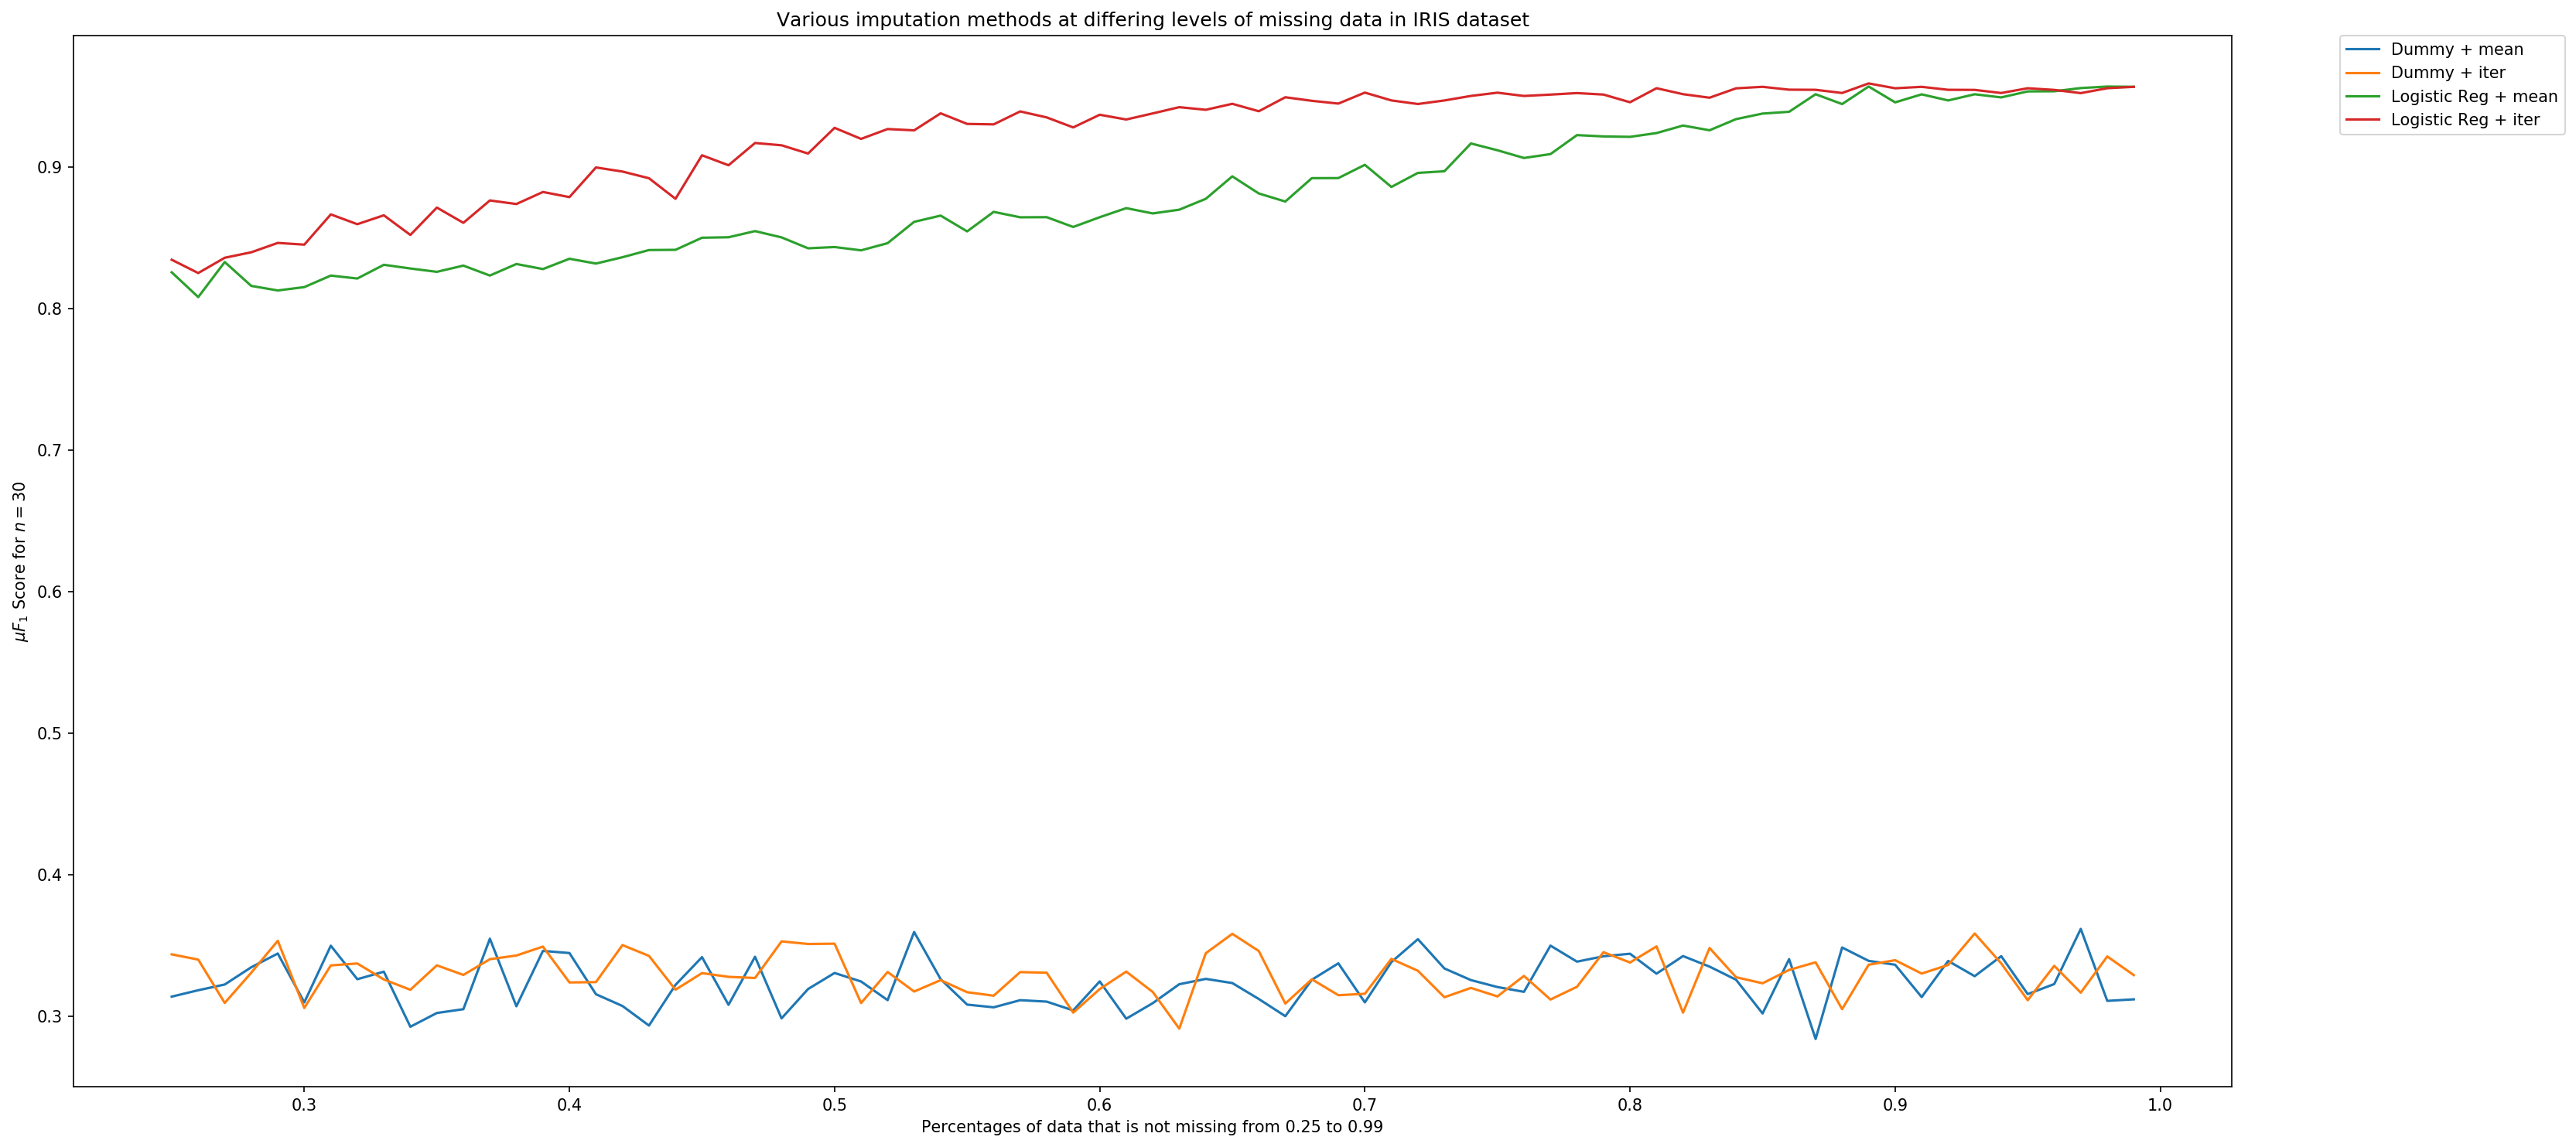

In [12]:
def run_experiment():
    iris = datasets.load_iris()
    raw_df = pd.DataFrame.from_dict({**{feature:list(map(lambda row: row[idx], iris["data"])) 
                              for idx, feature in enumerate(iris["feature_names"])},
                               **{"class":iris["target"]}})
    X_raw, y_raw = raw_df.iloc[:,0:-1], raw_df.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw, test_size=0.2, random_state=random.randint(1,101)
    )
    scaler = StandardScaler()
    scaler.fit(X_train) # Scaler was fit on the training data only
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_train_percentage = {
        percentage:{"dirty":drop_percentage(X_train, percentage)} for percentage in percentages()
    }
    for percentage in percentages():
        def get_dirty_data(): return X_train_percentage[percentage]["dirty"]
        X_train_percentage[percentage]["clean"] = {
            "mean":SimpleImputer().fit_transform(get_dirty_data()),
            "iter":IterativeImputer().fit_transform(get_dirty_data())
        }
    all_scores = {method:{} for method in methods()}
    for method, percentage in method_perc_cartprod():
        all_scores[method][percentage] = get_scores(
            X_train_percentage[percentage]["clean"][method], y_train, X_test, y_test
        )
    return all_scores


all_scores = {}
for method in methods():
    all_scores[method] = {percentage:{"dummy":[],"logisticreg":[]} for percentage in percentages()}
    
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

for _ in range(30):
    print(f"Running experiment iteration no. {_+1}")
    scores = run_experiment()
    for method, percentage, clf in itertools.product(methods(), list(percentages()), ["dummy", "logisticreg"]):
        all_scores[method][percentage][clf].append(scores[method][percentage][clf].values[0])
        
        
figure(num=None, figsize=(24, 12), dpi=150, facecolor='w', edgecolor='k')
dummy_lines = {
    method:plt.plot(percentages(), [
        np.mean(all_scores[method][percentage]["dummy"]) for percentage in percentages()
    ], label=f"Dummy + {method}") for method in methods()
}
logisticreg_lines = {
    method:plt.plot(percentages(), [
        np.mean(all_scores[method][percentage]["logisticreg"]) for percentage in percentages()
    ], label=f"Logistic Reg + {method}") for method in methods()
}
plt.xlabel(f"Percentages of data that is not missing from {percentages()[0]:.2f} to {percentages()[-1]:.2f}")
plt.ylabel(f"$\mu F_1$ Score for $n=30$")
plt.title("Various imputation methods at differing levels of missing data in IRIS dataset")
plt.gca().legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### The above figure suggests that when more data is missing the iterative imputer performs better with regards to the $\mu$ $F_1$ score where $n=30$. However, it also suggests that as the amount of missing data elements approaches $0$ that the difference between the two methods in terms of performance shrinks.